In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add

from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.applications.xception import Xception, preprocess_input

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

## Data Loading and Preprocessing

In [5]:

image_path = "/content/drive/MyDrive/proj_captioning/Flickr8k_Dataset/Flicker8k_Dataset"
dir_Flickr_text = "/content/drive/MyDrive/proj_captioning/Flickr8k_text/Flickr8k.token.txt"
jpgs = os.listdir(image_path)
print("Total Images in Dataset = {}".format(len(jpgs)))

Total Images in Dataset = 8091


## We create a dataframe to store the image id and captions for ease of use

In [6]:
file = open(dir_Flickr_text,'r')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
   col = line.split('\t')
   if len(col) == 1:
       continue
   w = col[0].split("#")
   datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["filename","index","caption"])
data = data.reindex(columns =['index','filename','caption'])
data = data[data.filename != '2258277193_586949ec62.jpg.1']
uni_filenames = np.unique(data.filename.values)

data.head()

,index,filename,caption
0,0,1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set o...
1,1,1000268201_693b08cb0e.jpg,a girl going into a wooden building .
2,2,1000268201_693b08cb0e.jpg,a little girl climbing into a wooden playhouse .
3,3,1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playh...
4,4,1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a woo...


## Visualizing few images with there corresponding captions

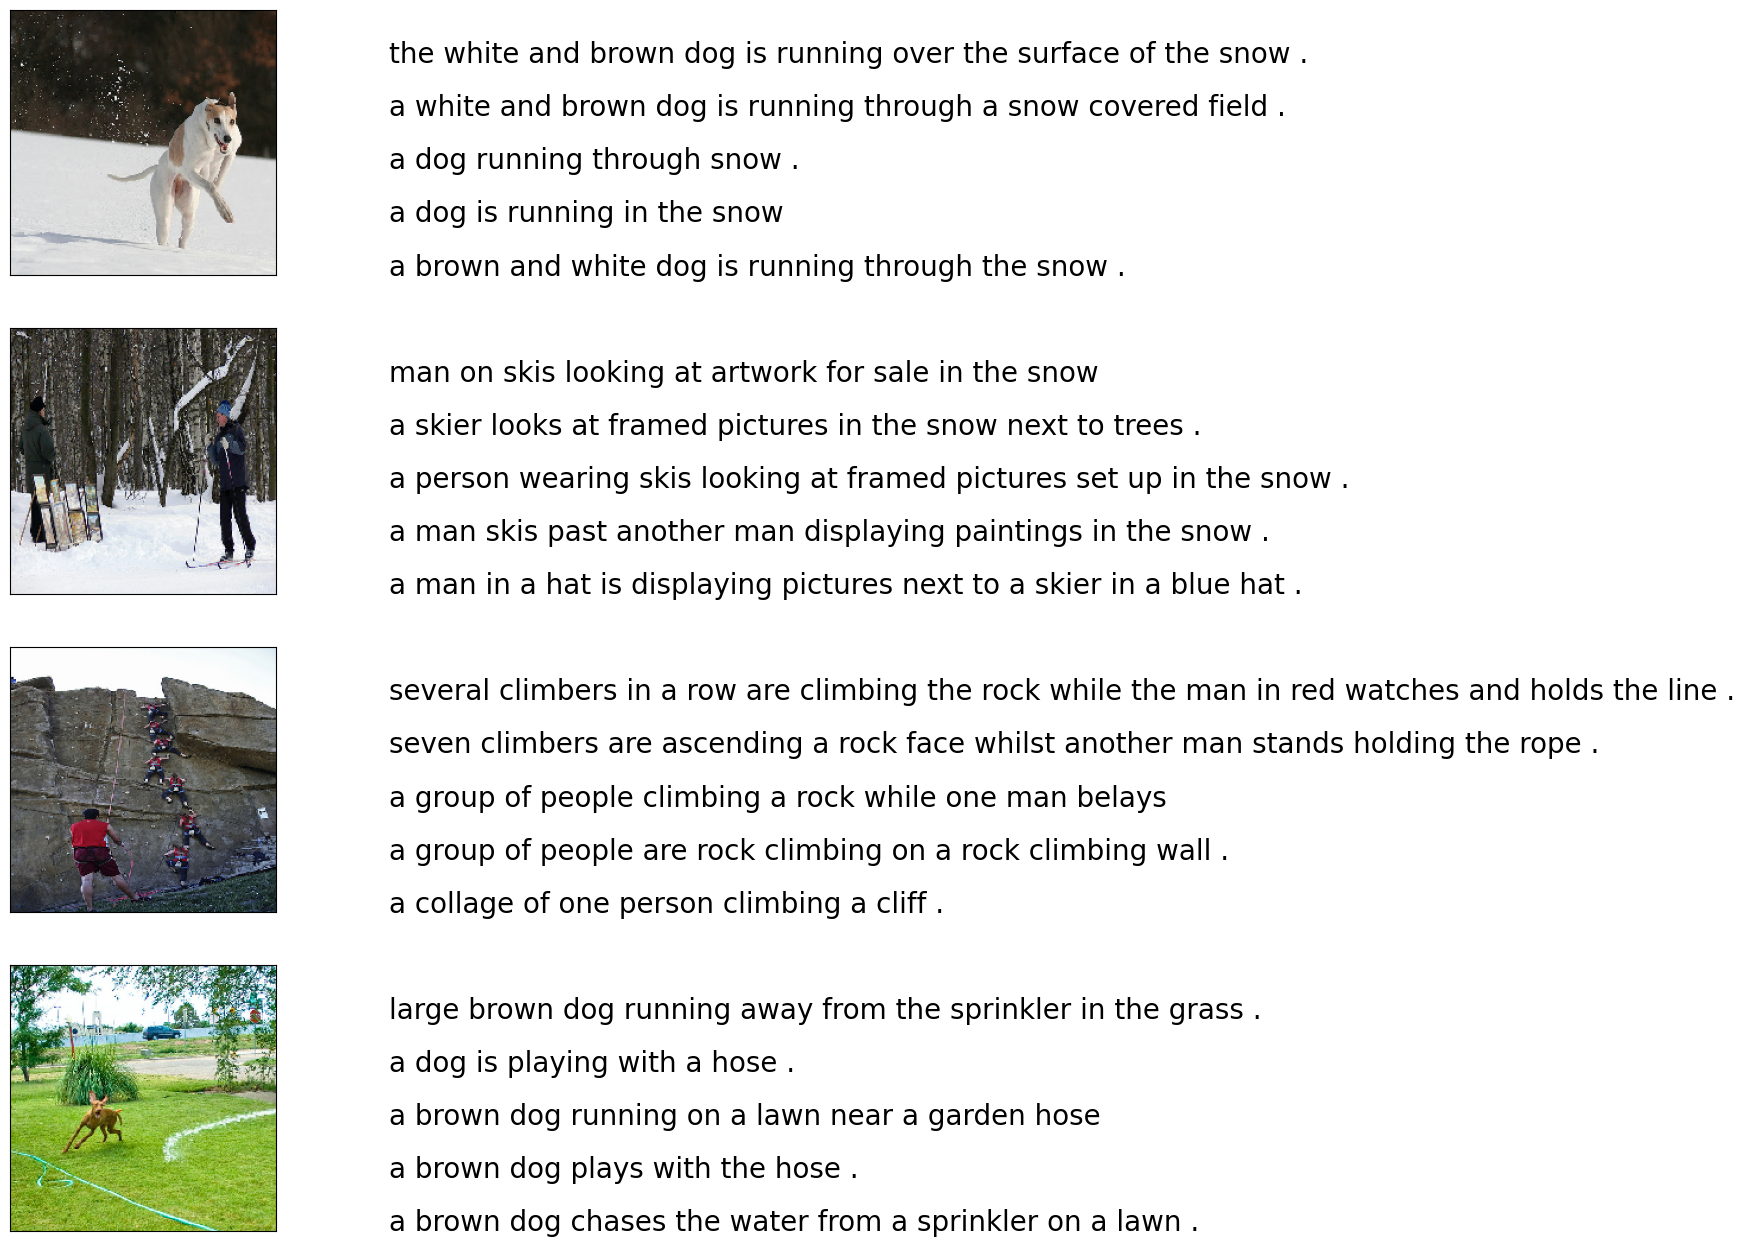

In [7]:
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:14]:
   filename = image_path + '/' + jpgfnm
   captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
   image_load = load_img(filename, target_size=target_size)
   ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
   ax.imshow(image_load)
   count += 1

   ax = fig.add_subplot(npic,2,count)
   plt.axis('off')
   ax.plot()
   ax.set_xlim(0,1)
   ax.set_ylim(0,len(captions))
   for i, caption in enumerate(captions):
       ax.text(0,i,caption,fontsize=20)
   count += 1
plt.show()

In [8]:

## Vocabulary Size
vocabulary = []
for txt in data.caption.values:
   vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))

Vocabulary Size: 8918


## Text preprocessing steps --


*   Removing Punctuation
*   Removing single characters
*   Removing Numeric values






In [9]:
def remove_punctuation(text_original):
   text_no_punctuation = text_original.translate(string.punctuation)
   return(text_no_punctuation)

def remove_single_character(text):
   text_len_more_than1 = ""
   for word in text.split():
       if len(word) > 1:
           text_len_more_than1 += " " + word
   return(text_len_more_than1)

def remove_numeric(text):
   text_no_numeric = ""
   for word in text.split():
       isalpha = word.isalpha()
       if isalpha:
           text_no_numeric += " " + word
   return(text_no_numeric)

def text_clean(text_original):
   text = remove_punctuation(text_original)
   text = remove_single_character(text)
   text = remove_numeric(text)
   return(text)

for i, caption in enumerate(data.caption.values):
   newcaption = text_clean(caption)
   data["caption"].iloc[i] = newcaption

In [10]:
## Vocabulary Size after cleaning

clean_vocabulary = []
for txt in data.caption.values:
   clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))

Clean Vocabulary Size: 8357


## Adding <start> and <end> tags for every caption, so that model understands the start and end of each caption

In [20]:
PATH = "/content/drive/MyDrive/proj_captioning/Flickr8k_Dataset/Flicker8k_Dataset/"
all_captions = []
for caption  in data["caption"].astype(str):
   caption = '<start> ' + caption+ ' <end>'
   all_captions.append(caption)

all_captions[:10]

['<start>  child in pink dress is climbing up set of stairs in an entry way <end>',
 '<start>  girl going into wooden building <end>',
 '<start>  little girl climbing into wooden playhouse <end>',
 '<start>  little girl climbing the stairs to her playhouse <end>',
 '<start>  little girl in pink dress going into wooden cabin <end>',
 '<start>  black dog and spotted dog are fighting <end>',
 '<start>  black dog and dog playing with each other on the road <end>',
 '<start>  black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start>  two dogs of different breeds looking at each other on the road <end>',
 '<start>  two dogs on pavement moving toward each other <end>']

In [21]:

all_img_name_vector = []
for annot in data["filename"]:
   full_image_path = PATH + annot
   all_img_name_vector.append(full_image_path)

all_img_name_vector[:10]

['/content/drive/MyDrive/proj_captioning/Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/proj_captioning/Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/proj_captioning/Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/proj_captioning/Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/proj_captioning/Flickr8k_Dataset/Flicker8k_Dataset/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/proj_captioning/Flickr8k_Dataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/proj_captioning/Flickr8k_Dataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/proj_captioning/Flickr8k_Dataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/proj_captioning/Flickr8k_Dataset/Flicker8k_Dataset/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/proj_captioning/Flickr8k_Dataset/Flicke

In [22]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


## Limiting our captions and images to 40000 ao that we can use batch_size  = 64 and we have 625  batches in total

In [23]:
def data_limiter(num,total_captions,all_img_name_vector):
 train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
 train_captions = train_captions[:num]
 img_name_vector = img_name_vector[:num]
 return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(40000,all_captions,all_img_name_vector)
print(f"len(train_captions) : {len(train_captions)}")
print(f"len(img_name_vector) : {len(img_name_vector)}")

len(train_captions) : 40000
len(img_name_vector) : 40000


## Model Defintion --
We will be using VGG16 as image feature extraction model. We will be extracting an image vector for our images. Hence we will remove the softmax layer from the model

In [24]:
def load_image(image_path):
   img = tf.io.read_file(image_path)
   img = tf.image.decode_jpeg(img, channels=3)
   img = tf.image.resize(img, (224, 224))
   img = preprocess_input(img)
   return img, image_path

image_model = tf.keras.applications.Xception(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

image_features_extract_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 32)       864       ['input_2[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, None, None, 32)       128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, None, None, 32)       0         ['block1_conv1_bn[0][0]'

Mapping each image name to the function to load an image

In [25]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [26]:
features_dict ={}

In [ ]:

%%time
for img, path in tqdm(image_dataset):
 batch_features = image_features_extract_model(img)
 batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))

 for bf, p in zip(batch_features, path):
   path_of_feature = p.numpy().decode("utf-8")
   features_dict[path_of_feature]=bf



In [ ]:
with open('/content/drive/MyDrive/TELUGU/features_dict_xce.pickle', 'wb') as handle:
    pickle.dump(features_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
with open('/content/drive/MyDrive/TELUGU/features_dict_xce.pickle', 'rb') as handle:
    loaded_features_dict = pickle.load(handle)

In [27]:
%%time
for img, path in tqdm(image_dataset):
 batch_features = image_features_extract_model(img)
 batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))

100%|██████████| 127/127 [26:21<00:00, 12.46s/it]

CPU times: user 42.5 s, sys: 3.4 s, total: 45.9 s
Wall time: 26min 21s


In [44]:
%%time
for img, path in tqdm(image_dataset):
 batch_features = image_features_extract_model(img)
 batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))

 for bf, p in zip(batch_features, path):
   path_of_feature = p.numpy().decode("utf-8")
   np.save(path_of_feature, bf.numpy())

100%|██████████| 127/127 [02:51<00:00,  1.35s/it]

CPU times: user 1min 3s, sys: 5.45 s, total: 1min 8s
Wall time: 2min 51s


In [28]:
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')

tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [ ]:
from pickle import dump, load

In [ ]:
dump(tokenizer, open('/content/drive/MyDrive/TELUGU/tokenizer_atten_xce.p', 'wb'))

In [ ]:
from pickle import dump, load
tokenizer = load(open('/content/drive/MyDrive/TELUGU/tokenizer_atten_xce.p', 'rb'))

In [29]:
train_captions[:3]

['<start>  several children leaping into pile of leaves on the ground <end>',
 '<start>  man hiking in the wilderness giving the camera thumbs up <end>',
 '<start>  white dog is running through the water onto the shore <end>']

In [30]:
train_seqs[:3]

[[2, 184, 62, 331, 64, 524, 12, 329, 6, 5, 167, 3],
 [2, 11, 588, 4, 5, 2384, 895, 5, 93, 1281, 53, 3],
 [2, 14, 9, 7, 32, 33, 5, 24, 238, 5, 280, 3]]

In [31]:
def calc_max_length(tensor):
   return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)

def calc_min_length(tensor):
   return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 33 : 2


In [32]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.2, random_state=0)

In [33]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = len(tokenizer.word_index) + 1
num_steps = len(img_name_train) // BATCH_SIZE
features_shape = 512
attention_features_shape = 49

In [42]:

def map_func(img_name, cap):
 img_tensor = np.load(img_name.decode('utf-8')+'.npy')
 return img_tensor, cap
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
        map_func, [item1, item2], [tf.float32, tf.int32]),
         num_parallel_calls=tf.data.experimental.AUTOTUNE)

dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)




## Using the model Architecture from "A Neural Image Caption Generator"

Encoder - Decoder architecture with Attention

In [35]:
class Xception_Encoder(tf.keras.Model):
   # This encoder passes the features through a Fully connected layer
   def __init__(self, embedding_dim):
       super(Xception_Encoder, self).__init__()
       # shape after fc == (batch_size, 49, embedding_dim)
       self.fc = tf.keras.layers.Dense(embedding_dim)
       self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)

   def call(self, x):
       #x= self.dropout(x)
       x = self.fc(x)
       x = tf.nn.relu(x)
       return x

In [37]:
'''The encoder output(i.e. 'features'), hidden state(initialized to 0)(i.e. 'hidden') and
the decoder input (which is the start token)(i.e. 'x') is passed to the decoder.'''

class Rnn_Local_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(Rnn_Local_Decoder, self).__init__()
    self.units = units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                  return_sequences=True,
                                  return_state=True,
                                  recurrent_initializer='glorot_uniform')

    self.fc1 = tf.keras.layers.Dense(self.units)

    self.dropout = tf.keras.layers.Dropout(0.5, noise_shape=None, seed=None)
    self.batchnormalization = tf.keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

    self.fc2 = tf.keras.layers.Dense(vocab_size)

    # Implementing Attention Mechanism
    self.Uattn = tf.keras.layers.Dense(units)
    self.Wattn = tf.keras.layers.Dense(units)
    self.Vattn = tf.keras.layers.Dense(1)

  def call(self, x, features, hidden):
    # features shape ==> (64,49,256) ==> Output from ENCODER
    # hidden shape == (batch_size, hidden_size) ==>(64,512)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size) ==> (64,1,512)

    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # score shape == (64, 49, 1)
    # Attention Function
    '''e(ij) = f(s(t-1),h(j))'''
    ''' e(ij) = Vattn(T)*tanh(Uattn * h(j) + Wattn * s(t))'''

    score = self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)))

    # self.Uattn(features) : (64,49,512)
    # self.Wattn(hidden_with_time_axis) : (64,1,512)
    # tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis)) : (64,49,512)
    # self.Vattn(tf.nn.tanh(self.Uattn(features) + self.Wattn(hidden_with_time_axis))) : (64,49,1) ==> score

    # you get 1 at the last axis because you are applying score to self.Vattn
    # Then find Probability using Softmax
    '''attention_weights(alpha(ij)) = softmax(e(ij))'''

    attention_weights = tf.nn.softmax(score, axis=1)

    # attention_weights shape == (64, 49, 1)
    # Give weights to the different pixels in the image
    ''' C(t) = Summation(j=1 to T) (attention_weights * VGG-16 features) '''

    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    # Context Vector(64,256) = AttentionWeights(64,49,1) * features(64,49,256)
    # context_vector shape after sum == (64, 256)
    # x shape after passing through embedding == (64, 1, 256)

    x = self.embedding(x)
    # x shape after concatenation == (64, 1,  512)

    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    # passing the concatenated vector to the GRU

    output, state = self.gru(x)
    # shape == (batch_size, max_length, hidden_size)

    x = self.fc1(output)
    # x shape == (batch_size * max_length, hidden_size)

    x = tf.reshape(x, (-1, x.shape[2]))

    # Adding Dropout and BatchNorm Layers
    x= self.dropout(x)
    x= self.batchnormalization(x)

    # output shape == (64 * 512)
    x = self.fc2(x)

    # shape : (64 * 8329(vocab))
    return x, state, attention_weights
  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))


encoder = Xception_Encoder(embedding_dim)
decoder = Rnn_Local_Decoder(embedding_dim, units, vocab_size)

In [38]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
   from_logits=True, reduction='none')

def loss_function(real, pred):
 mask = tf.math.logical_not(tf.math.equal(real, 0))
 loss_ = loss_object(real, pred)
 mask = tf.cast(mask, dtype=loss_.dtype)
 loss_ *= mask

 return tf.reduce_mean(loss_)

In [39]:
loss_plot = []

@tf.function
def train_step(img_tensor, target):
 loss = 0
 # initializing the hidden state for each batch
 # because the captions are not related from image to image

 hidden = decoder.reset_state(batch_size=target.shape[0])
 dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

 with tf.GradientTape() as tape:
     features = encoder(img_tensor)
     for i in range(1, target.shape[1]):
         # passing the features through the decoder
         predictions, hidden, _ = decoder(dec_input, features, hidden)
         loss += loss_function(target[:, i], predictions)

         # using teacher forcing
         dec_input = tf.expand_dims(target[:, i], 1)

 total_loss = (loss / int(target.shape[1]))
 trainable_variables = encoder.trainable_variables + decoder.trainable_variables
 gradients = tape.gradient(loss, trainable_variables)
 optimizer.apply_gradients(zip(gradients, trainable_variables))

 return loss, total_loss

## Training

In [45]:
start_epoch=0
EPOCHS = 10
for epoch in range(start_epoch, EPOCHS):
   start = time.time()
   total_loss = 0

   for (batch, (img_tensor, target)) in enumerate(dataset):
       batch_loss, t_loss = train_step(img_tensor, target)
       total_loss += t_loss

       if batch % 100 == 0:
           print ('Epoch {} Batch {} Loss {:.4f}'.format(
             epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
   # storing the epoch end loss value to plot later
   loss_plot.append(total_loss / num_steps)
   print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                        total_loss/num_steps))

   print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.8150
Epoch 1 Batch 100 Loss 1.6270
Epoch 1 Batch 200 Loss 1.1970
Epoch 1 Batch 300 Loss 1.1433
Epoch 1 Batch 400 Loss 1.2236
Epoch 1 Loss 1.415520
Time taken for 1 epoch 201.5159556865692 sec

Epoch 2 Batch 0 Loss 1.0899
Epoch 2 Batch 100 Loss 1.1042
Epoch 2 Batch 200 Loss 1.1457
Epoch 2 Batch 300 Loss 1.1316
Epoch 2 Batch 400 Loss 1.0962
Epoch 2 Loss 1.110736
Time taken for 1 epoch 137.5433497428894 sec

Epoch 3 Batch 0 Loss 1.0122
Epoch 3 Batch 100 Loss 0.9766
Epoch 3 Batch 200 Loss 0.9097
Epoch 3 Batch 300 Loss 0.9693
Epoch 3 Batch 400 Loss 0.9067
Epoch 3 Loss 1.006082
Time taken for 1 epoch 137.67390513420105 sec

Epoch 4 Batch 0 Loss 0.9666
Epoch 4 Batch 100 Loss 0.8496
Epoch 4 Batch 200 Loss 0.9704
Epoch 4 Batch 300 Loss 0.9460
Epoch 4 Batch 400 Loss 0.8431
Epoch 4 Loss 0.930111
Time taken for 1 epoch 135.56597447395325 sec

Epoch 5 Batch 0 Loss 0.7595
Epoch 5 Batch 100 Loss 0.8877
Epoch 5 Batch 200 Loss 0.9262
Epoch 5 Batch 300 Loss 0.8476
Epoch 5 Batch 40

In [54]:

EPOCHS = 10
for epoch in range(start_epoch, EPOCHS):
   start = time.time()
   total_loss = 0

   for (batch, (img_tensor, target)) in enumerate(dataset):
       batch_loss, t_loss = train_step(img_tensor, target)
       total_loss += t_loss

       if batch % 100 == 0:
           print ('Epoch {} Batch {} Loss {:.4f}'.format(
             epoch + 1, batch, batch_loss.numpy() / int(target.shape[1])))
   # storing the epoch end loss value to plot later
   loss_plot.append(total_loss / num_steps)
   print ('Epoch {} Loss {:.6f}'.format(epoch + 1,
                                        total_loss/num_steps))

   print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.5999
Epoch 1 Batch 100 Loss 0.5507
Epoch 1 Batch 200 Loss 0.6070
Epoch 1 Batch 300 Loss 0.5736
Epoch 1 Batch 400 Loss 0.6263
Epoch 1 Loss 0.592899
Time taken for 1 epoch 140.77959847450256 sec

Epoch 2 Batch 0 Loss 0.6104
Epoch 2 Batch 100 Loss 0.5915
Epoch 2 Batch 200 Loss 0.5239
Epoch 2 Batch 300 Loss 0.5817
Epoch 2 Batch 400 Loss 0.5414
Epoch 2 Loss 0.559058
Time taken for 1 epoch 139.72583651542664 sec

Epoch 3 Batch 0 Loss 0.5484
Epoch 3 Batch 100 Loss 0.4694
Epoch 3 Batch 200 Loss 0.4855
Epoch 3 Batch 300 Loss 0.4686
Epoch 3 Batch 400 Loss 0.5388
Epoch 3 Loss 0.526250
Time taken for 1 epoch 140.1007900238037 sec

Epoch 4 Batch 0 Loss 0.5199
Epoch 4 Batch 100 Loss 0.5389
Epoch 4 Batch 200 Loss 0.5776
Epoch 4 Batch 300 Loss 0.5231
Epoch 4 Batch 400 Loss 0.5311
Epoch 4 Loss 0.496836
Time taken for 1 epoch 142.41124510765076 sec

Epoch 5 Batch 0 Loss 0.4848
Epoch 5 Batch 100 Loss 0.4652
Epoch 5 Batch 200 Loss 0.4893
Epoch 5 Batch 300 Loss 0.4796
Epoch 5 Batch 4

In [58]:
# Assuming you have trained the models and have instances of encoder and decoder

# Save encoder model
encoder.save("/content/drive/MyDrive/proj_captioning/encoder_model_xce")

# Save decoder model
decoder.save("/content/drive/MyDrive/proj_captioning/decoder_model_xce")


In [59]:
image_features_extract_model.save("/content/drive/MyDrive/proj_captioning/atten_model_Xcep")

In [ ]:
# Load encoder model
encoder = tf.keras.models.load_model("/content/drive/MyDrive/proj_captioning/encoder_model_xce")


# Load decoder model
decoder = tf.keras.models.load_model("/content/drive/MyDrive/proj_captioning/decoder_model_xce")


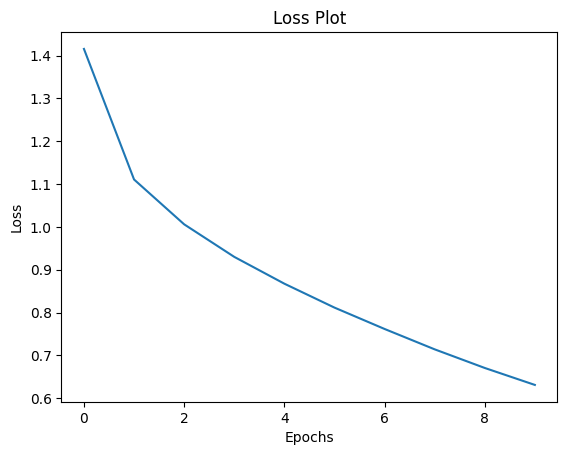

In [48]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [49]:
def evaluate(image):
   attention_plot = np.zeros((max_length, attention_features_shape))

   hidden = decoder.reset_state(batch_size=1)
   temp_input = tf.expand_dims(load_image(image)[0], 0)
   img_tensor_val = image_features_extract_model(temp_input)
   img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

   features = encoder(img_tensor_val)
   dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
   result = []

   for i in range(max_length):
       predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
       attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()
       predicted_id = tf.argmax(predictions[0]).numpy()
       result.append(tokenizer.index_word[predicted_id])

       if tokenizer.index_word[predicted_id] == '<end>':
           return result, attention_plot

       dec_input = tf.expand_dims([predicted_id], 0)
   attention_plot = attention_plot[:len(result), :]

   return result, attention_plot

In [50]:

def plot_attention(image, result, attention_plot):
   temp_image = np.array(Image.open(image))
   fig = plt.figure(figsize=(10, 10))
   len_result = len(result)
   for l in range(len_result):
       temp_att = np.resize(attention_plot[l], (8, 8))
       ax = fig.add_subplot(len_result//2, len_result//2, l+1)
       ax.set_title(result[l])
       img = ax.imshow(temp_image)
       ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

   plt.tight_layout()
   plt.show()

## Evaluation

BELU score: 6.373704167435468e-153
Real Caption: A dog is running in the grass
Prediction Caption: child in pink hat is playing in the background


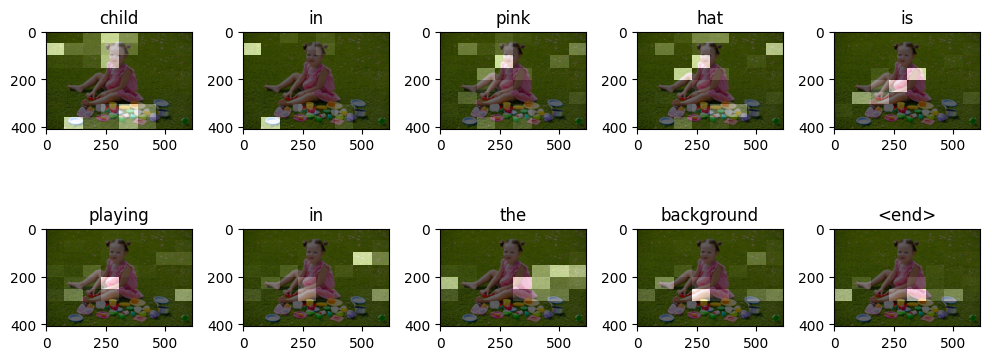

In [57]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = '/content/drive/MyDrive/proj_captioning/8.jpg'

#real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
#first = real_caption.split(' ', 1)[1]
real_caption = 'A dog is running in the grass'

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)

BELU score: 7.176381577237209e-153
Real Caption: Two white dogs are playing in the snow
Prediction Caption: two white dogs run across the woods


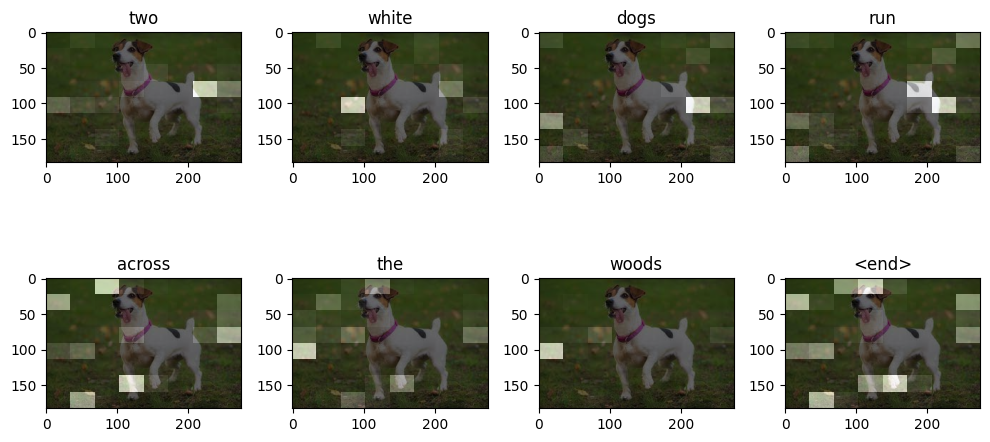

In [56]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = '/content/drive/MyDrive/proj_captioning/12.jpg'

#real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

# remove <start> and <end> from the real_caption
#first = real_caption.split(' ', 1)[1]
real_caption = 'Two white dogs are playing in the snow'

#remove "<unk>" in result
for i in result:
   if i=="<unk>":
       result.remove(i)

for i in real_caption:
   if i=="<unk>":
       real_caption.remove(i)

#remove <end> from result
result_join = ' '.join(result)
result_final = result_join.rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())

reference = real_appn
candidate = result

score = sentence_bleu(reference, candidate)
print(f"BELU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', result_final)
plot_attention(image, result, attention_plot)